การควบคุมเหมาะที่สุดและการเรียนรูู้เสริมกำลัง -- ดร.วโรดม ตู้จินดา

# 2A	พื้นฐานการหาค่าเหมาะที่สุด

เนื่องจากผู้เขียนได้ทดสอบการใช้ pytorch ในภายหลัง เพื่อมิให้โค้ดในสมุดบันทึกหลักของหนังสือมีความซับซ้อนเกินไป จึงรวบรวมตัวอย่างและโค้ดสำหรับกรณีที่ใช้ pytorch ไว้ในสมุดบันทึกเสริมนี้

[กลับสู่บทที่ 2](chapter2.ipynb)

* [ตัวอย่าง 2.2](#ex2_2)
* [ตัวอย่าง 2.6](#ex2_6)
* [ตัวอย่าง 2.8](#ex2_8)
* [ตัวอย่าง 2.9](#ex2_9)
* [ตัวอย่าง 2.10](#ex2_10)

***

<a id="ex2_2"></a>

### ตัวอย่าง 2.2

พิจารณาพลวัตของลูกตุ้มในรูปที่ 2.2 เมื่อไม่มีอินพุต สามารถบรรยายโดยสมการการเคลื่อนที่ดังนี้

$$
ml^2 \ddot{\theta} + mgl\; sin(\theta) = 0 \tag{2.6}
$$

![Fig2.2](https://raw.githubusercontent.com/dewdotninja/ocrl/refs/heads/main/doc/figs/fig2_2.png)

รูปที่ 2.2 ลูกตุ้มสำหรับตัวอย่าง 2.2

เมื่อกำหนดสถานะ $x = [\theta \;\; \dot{\theta}]^T$ จะเขียนอยู่ในรูปเมทริกซ์ได้เป็น

$$
\dot x = \left[\begin{array}{c}
\dot{\theta} \\
\ddot{\theta}
\end{array} \right] =
\left[ \begin{array}{c}
\dot{\theta} \\
-\frac{g}{l}sin(\theta) 
\end{array} \right] \tag{2.7}
$$

หากต้องการจำลองพลวัตของลูกตุ้มบนคอมพิวเตอร์ จะต้องแปลงระบบให้อยู่ในรูปเวลาวิยุตซึ่งทำได้หลายวิธี วิธีการหนึ่งที่จะแสดงในตัวอย่างนี้โดยการหาค่ารากหรือวิธีจุดตรึงเรียกว่า *วิธีออยเลอร์ย้อนหลัง (backward Euler method)* เขียนได้ดังนี้

$$
x_{k+1} = x_k+hf(x_{k+1}) \tag{2.8}
$$

โดย $h$ คือ*ค่าขั้นเวลา (time step)* สังเกตว่าค่าของสถานะ $x_{k+1}$ ใน (2.5) ขึ้นกับ $f(x_{k+1})$  ซึ่งไม่สามารถคำนวณได้โดยตรง แต่เมื่อจัดรูปใหม่เป็น

$$
x_k + hf(x_{k+1})-x_{k+1}=0 \tag{2.9}
$$

จะกลายเป็นโจทย์ที่สามารถใช้วิธีหาค่ารากหรือวิธีจุดตรึงได้ จะใช้ทั้งสองวิธีเพื่อเปรียบเทียบกัน 

นำเข้าแพ็กเกจที่ต้องการใช้จาก torch.linalg คือ norm  สำหรับคำนวณค่าแตกต่างและ solve สำหรับการหาคำตอบที่ต้องทำเมทริกซ์ผกผัน (โดย solve(A,B) เปรียบได้กับ A\B ในภาษาอื่นเช่นจูเลีย)  สำหรับการคำนวณอนุพันธ์อัตโนมัติจะใช้ jacfwd จาก torch.func ศึกษารายละเอียดเพิ่มเติมได้จากภาคผนวก C1 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
from torch.linalg import norm, solve
from torch.func import jacfwd

สร้างฟังก์ชันจำลองพลวัตของลูกตุ้ม โดยกำหนดความยาวก้านต่อเท่ากับ 1.0 เมตร

In [2]:
def pendulum_dynamics(x):
    l = 1.0
    g = 9.81
    y = torch.zeros(2)
    y[0] = x[1]
    y[1] = -(g/l)*torch.sin(x[0])
    return y 

เริ่มจากวิธีการจุดตรึง สร้างฟังก์ชันสำหรับแต่ละขั้นของออยเลอร์ย้อนหลัง

In [3]:
def backward_euler_step_fixed_point(func, x0, h):
    xn = x0
    e = [norm(x0 + h*func(xn) - xn)]
    while e[-1] > 1e-8:
        xn = x0 + h*func(xn)
        e.append(norm(x0 + h*func(xn) - xn))    
    return xn, e

จะเห็นว่าในแต่ละขั้น ฟังก์ชันมีการคำนวณค่าแตกต่างระหว่างด้านซ้ายและขวาใน (2.8) และวนซ้ำจนกว่าค่าแตกต่างจะน้อยกว่าพิกัดที่กำหนด เช่น 1e-8 หลังจากนิยามฟังก์ชันขั้นแล้ว สร้างฟังก์ชันรวมสำหรับการจำลองในช่วงเวลาที่กำหนดโดยเวลาสิ้นสุด  Tf

In [18]:
def backward_euler_fixed_point(func, x0, Tf, h):
    t = np.arange(0,Tf,h)
    x_hist = torch.zeros(len(x0),len(t))
    x_hist[:,0] = x0
    for k in range(len(t)-1):
        x_hist[:,k+1],e = backward_euler_step_fixed_point(func,x_hist[:,k],h)
    
    return x_hist, t

สำหรับวิธีการนิวตัน นิยามฟังก์ชันพลวัตห่อหุ้ม pendulum_dynamics_implicit() 

In [33]:
def pendulum_dynamics_implicit(x,x0,h):
    return x0 + h*pendulum_dynamics(x) - x

ใช้การคำนวณอนุพันธ์โดย jacfwd เขียนฟังก์ชันได้ดังนี้

In [40]:
def backward_euler_step_newton(func, x0, h):
    xn = x0
    r = func(xn,x0,h)
    e = [norm(r)]
    while e[-1] > 1e-8:
        dr = jacfwd(func,argnums=0)(xn,x0,h)
        xn = xn - solve(dr,r) # use solve(A,B) in place of A\B
        r = func(xn,x0,h)
        e.append(norm(r))
    
    return xn, e

In [35]:
def backward_euler_newton(func, x0, Tf, h):
    t = np.arange(0,Tf,h)
    x_hist = torch.zeros(len(x0),len(t))
    x_hist[:,0] = x0
    for k in range(len(t)-1):
        x_hist[:,k+1],e = backward_euler_step_newton(func,x_hist[:,k],h)
    
    return x_hist, t

เมื่อจำลองพลวัตของลูกตุ้มแบบออยเลอร์ย้อนหลังโดยวิธีจุดตรึงและนิวตันเป็นเวลา 10 วินาที ได้ผลการเปรียบเทียบเป็นดังรูปที่ 2.3 

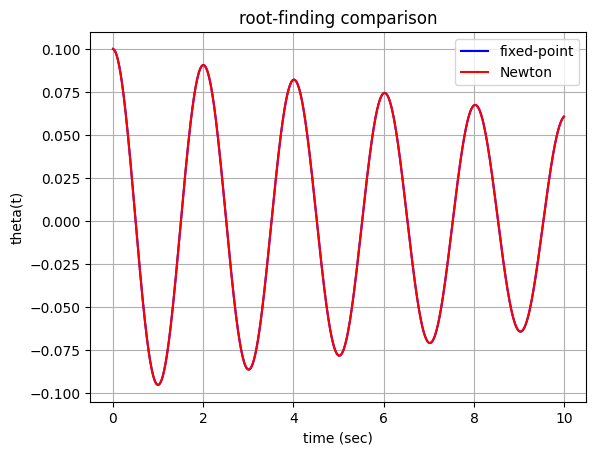

In [42]:
x0 = torch.tensor([.1,0])
x0g = torch.tensor([0.1,0],requires_grad=True)
h = 0.01
Tf = 10
x_hist1, t_hist1 = backward_euler_fixed_point(pendulum_dynamics, x0, Tf, h)
x_hist1_np = x_hist1.numpy()
x_hist2, t_hist2 = backward_euler_newton(pendulum_dynamics_implicit, x0g, Tf, h)
x_hist2_np = torch.squeeze(x_hist2.detach()).numpy()

plt.figure()
# plt.plot(t_hist1, x_hist1_np[0,:],'b-')
plt.plot(t_hist1, x_hist1_np[0,:],'b-',t_hist2, x_hist2_np[0,:],'r-')
plt.xlabel('time (sec)')
plt.ylabel('theta(t)')
plt.title('root-finding comparison')
plt.legend(['fixed-point','Newton'])
plt.grid(True)
plt.show()

รูปที่ 2.3 ผลการเปรียบเทียบการจำลองโดยวิธีจุดตรึงและวิธีนิวตัน

จากกราฟไม่สามารถสังเกตความแตกต่างได้โดยสายตา หากตรวจสอบจากค่าในแอเรย์ ณ จุดที่ความแตกต่างมากสุดพบว่ามีค่าน้อยระดับทศนิยม 6 ตำแหน่ง

In [43]:
max(abs(x_hist1_np[0,:]-x_hist2_np[0,:]))

np.float32(1.2710225e-06)

**หมายเหตุ :** ข้อสังเกตจากผลการจำลองพลวัตลูกตุ้มโดยวิธีออยเลอร์ย้อนหลังในรูปที่ 2.3 คือการแกว่งของเอาต์พุตมีระดับลดลง แม้ว่าไม่มีแรงเสียดทานหรือค่าความหน่วงในระบบ เป็นลักษณะเด่นประการหนึ่งของวิธีออยเลอร์ย้อนหลัง ซึ่งอาจเป็นสิ่งที่พึงประสงค์ในงานจำลองบางประเภทที่ต้องการเสถียรภาพดี หากต้องการให้ผลการจำลองใกล้เคียงกับระบบเวลาต่อเนื่องมากขึ้น ทดลองลดค่าขั้นเวลาลง เช่น 0.001 วินาที ระดับการแกว่งจะคงที่มากขึ้น

แม้ว่าผลการจำลองจะไม่แตกต่างกันมาก แต่เมื่อเปรียบเทียบความเร็วในการลู่เข้าในแต่ละขั้นของวิธีทั้งสอง โดยตั้งพิกัดของค่าแตกต่างเท่ากันคือ 1e-8 พบว่าวิธีจุดตรึงมีจำนวนการวนซ้ำหลายรอบกว่าจะได้ตามพิกัด

In [62]:
xn, e1 = backward_euler_step_fixed_point(pendulum_dynamics, x0, 0.1)
e1_np = []
for i in range(len(e1)):
    e1_np.append(e1[i].numpy())
    print(e1_np[i])

0.09793659
0.009793662
0.0095641315
0.00095641613
0.00093438476
9.343773e-05
9.127706e-05
9.126961e-06
8.910894e-06
8.940697e-07
8.6426735e-07
8.940697e-08
8.940697e-08
7.450581e-09


ส่วนวิธีนิวตันมีการวนซ้ำเพียง 3 รอบเท่านั้น และยังได้ค่าแตกต่างต่ำกว่าพิกัดมาก

In [63]:
xn, e2 = backward_euler_step_newton(pendulum_dynamics_implicit, x0g, 0.1)
e2_np = []
for i in range(len(e2)):
    e2_np.append(e2[i].detach().numpy())
    print(e2_np[i])

0.09793659
3.784895e-06
0.0


เมื่อพล็อตค่าความแตกต่างเทียบกับจำนวนรอบ จะได้ดังรูปที่  2.4

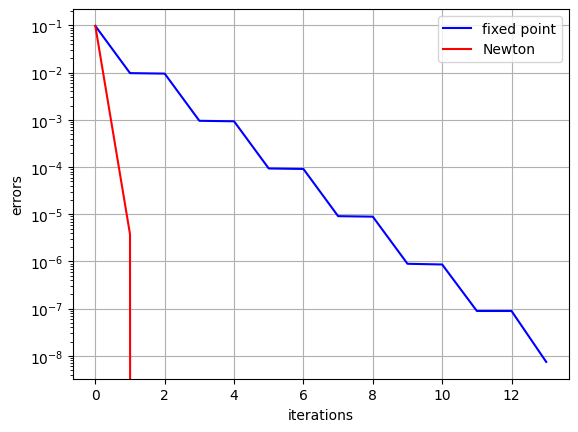

In [64]:
plt.figure()
plt.semilogy(e1_np,'b',e2_np,'r')
plt.xlabel('iterations')
plt.ylabel('errors')
plt.legend(['fixed point','Newton'])
plt.grid('True')
plt.show()

รูปที่ 2.4 เปรียบเทียบความเร็วในการลู่เข้าระหว่างวิธีจุดตรึงและวิธีนิวตัน

จากรูปที่ 2.4 จะเห็นว่าวิธีนิวตันมีสมรรถนะที่เหนือกว่าวิธีจุดตรึงอย่างเด่นชัด 
โดยจุดทศนิยมของค่าแตกต่างลดลงในรูปแบบของกำลังสองในขณะที่ค่าแตกต่างของวิธีจุดตรึงลดลงในรูปเชิงเส้น 
ทำให้วิธีนิวตันมักเป็นทางเลือกที่พึงประสงค์สำหรับการหาค่าราก และการประยุกต์ใช้กับการหาค่าต่ำสุดที่จะกล่าวถึงในหัวข้อต่อไป

การที่ค่าแตกต่างของวิธีนิวตันลดลงแบบกำลังสองสามารถอธิบายได้จาก (2.4) คือการกำหนดการประมาณค่าเชิงเส้นเป็นศูนย์
มีผลทำให้ค่าแตกต่างระหว่างการกระจายอนุกรมเทเลอร์กับฟังก์ชันจริงขึ้นอยู่กับพจนฺ์ที่เป็นอันดับสองขึ้นไปเท่านั้น

อย่างไรก็ตาม ในกรณีที่โจทย์ปัญหามีตัวแปรจำนวนมาก 
การค่าผกผันของเมทริกซ์จาโคเบียนขนาดใหญ่ทำให้วิธีนิวตันมีความซับซ้อนในการคำนวณมากกว่าวิธีจุดตรึง 
ดังนั้นในปัญหาขนาดใหญ่เช่นการเรียนรู้ของเครื่องที่มีข้อมูลจำนวนมาก วิธีจุดตรึงอาจเป็นทางเลือกที่เหมาะสมกว่า 

***


<a id="ex2_6"></a>

### ตัวอย่าง 2.6 

สำหรับตัวอย่างนี้จะใช้แพ็กเกจ torch ในการหาอนุพันธ์อัตโนมัติ โดย torch จะมีฟังก์ชันแทนที่ numpy ทั้งหมด ซึ่งเราต้องเรียกใช้แทน ตัวอย่างเช่น torch.linalg.solve แทน numpy.linalg.solve

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
from torch.linalg import norm, solve 
from torch.func import jacfwd

ในตัวอย่างนี้ใช้ข้อมูลเหมือนกับ [1] คือกำหนดฟังก์ชันมูลค่า $f(x)$ เกรเดียนต์ $\nabla f(x)$
และเฮสเซียน $\nabla^2 f(x)$ ด้วยข้อมูลดังนี้

In [ ]:
Q = torch.diag(torch.tensor([0.5,1]))

# objective function
def f(x):
    x1 = x - torch.tensor([[1],[0]])

    return 0.5*(x1.T@Q@x1)[0,0]

# gradient 
def df(x):
    x1 = x - torch.tensor([[1],[0]])
    return Q@x1

# hessian 
def d2f(x):
    return Q

กำหนดฟังก์ชันเงื่อนไขบังคับแบบสมการ $c(x)$ และเกรเดียนต์ $\nabla c(x)$ 

In [ ]:
# constraint and gradient
def c(x):
    return (x[0]**2 + 2*x[0] - x[1]) 

def dc(x):
    gradC = torch.zeros(1,2)
    gradC[0,0] = 2*x[0]+2
    gradC[0,1] = -1
    return gradC 

สร้างฟังก์ชัน plot_landscape() เพื่อแสดงเส้นโค้งระดับของ $f(x)$ และเงื่อนไข $c(x)=0$ 
ซ้อนกันในระนาบ 2 มิติ ดังแสดงในรูปที่ 2.11 ซึ่งค่าคำตอบ $x$ จะต้องอยู่บนเส้นกราฟสีส้ม 
และมีค่าของ $f(x)$ ต่ำที่สุด

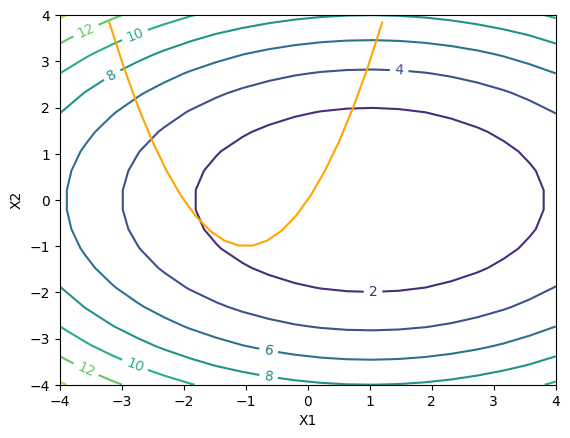

In [61]:
def plot_landscape():
    # plot level curve of f(x)
    Nsamp = 20
    x = np.linspace(-4,4,Nsamp)
    y = np.linspace(-4,4,Nsamp)
    X, Y = np.meshgrid(x,y)
    X = X.astype(np.float32)
    Y = Y.astype(np.float32)
    Z = np.zeros((Nsamp,Nsamp))
    for j in range(Nsamp):
        for k in range(Nsamp):
            Z[j,k] = f(torch.tensor([[X[j,k]], [Y[j,k]]]))
    fig, ax = plt.subplots()
    CS = ax.contour(X,Y,Z)
    ax.clabel(CS, fontsize = 10)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')

    # plot constraint c(x)
    xc = np.linspace(-3.2,1.2, Nsamp)
    yc = xc**2+2.0*xc
    ax.plot(xc,yc,'orange')

    return ax

ax = plot_landscape()   

รูปที่ 2.11 เส้นโค้งระดับของ $f(x)$ ซ้อนทับบนเงื่อนไขแบบสมการ $c(x)$

ในขั้นต้นจะใช้วิธีนิวตันคำนวณค่าแต่ละขั้นของ $x$ และ $\lambda$ จาก (2.23) 
เขียนเป็นฟังก์ชัน newton_step() ได้ดังนี้

In [ ]:
def newton_step(x0,lambda0):
    H = d2f(x0) + torch.squeeze(jacfwd(dc)(x0)).T*lambda0
    C = dc(x0)
    A = torch.vstack([torch.hstack([H,C.T]),torch.hstack([C,torch.zeros(1,1)])])
    B = torch.vstack([-df(x0)-C.T*lambda0, -c(x0)])

    dz = solve(A,B)
    dx = dz[0:2]
    dlambda = dz[2]
    return x0+dx, lambda0+dlambda

ทดลองเลือกค่าเริ่มต้น $[-1.0, -1.0]$ ดังรูปที่ 2.12

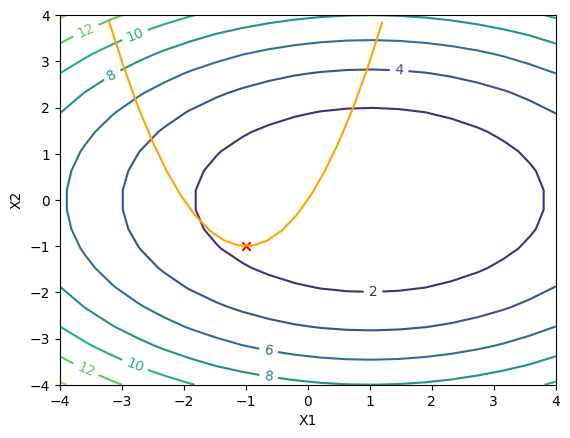

In [66]:
i=0
xguess = torch.tensor([[-1.0],[-1.0]],requires_grad=True)
lambdaguess = [0.0]
ax = plot_landscape()
xguess_np = xguess.detach().numpy()
ax.scatter(xguess_np[0], xguess_np[1],marker='x',color='r')
plt.show()

รูปที่ 2.12 เลือกค่าเริ่มต้น $x_0 = [-1.0, -1.0]$ 

สร้างฟังก์ชันสำหรับแสดงค่า $x$ ที่ถูกปรับ 
โดยแต่ละขั้นจะแสดงการเคลื่อนที่ของ $x$ เป็นเส้นตรงกำกับโดยลูกศร 

In [53]:
def plot_steps(xguess,i):
    ax = plot_landscape()
    ax.scatter(xguess[0,:], xguess[1,:],marker='x',color='g') 
    ax.scatter(xguess[0,-1], xguess[1,-1],marker='x',color='r')
    for ix in range(xguess.shape[1]-1):
        x1_old = xguess[0,ix]
        x1_new = xguess[0,ix+1]
        x2_old = xguess[1,ix]
        x2_new = xguess[1,ix+1]
        if np.linalg.norm(xguess[:,ix] - xguess[:,ix+1]).item() > 0.1: # plot arrow if distance large enough
            ax.arrow(x1_old,x2_old,(x1_new-x1_old)/2,(x2_new-x2_old)/2,head_width=0.1,color='m')
    ax.plot(xguess[0,:], xguess[1,:],'m') 
    ax.set_title('Iteration : '+str(i))

รันโค้ดในเซลล์นี้ซ้ำตามต้องการจนกว่าจะลู่เข้าสู่คำตอบ 
ดังแสดงในรูปที่ 2.13 ใช้จำนวนการวนซ้ำประมาณ 3-4 ครั้ง คำตอบอยู่ที่ค่าประมาณ $x = [0.1,0.2]$

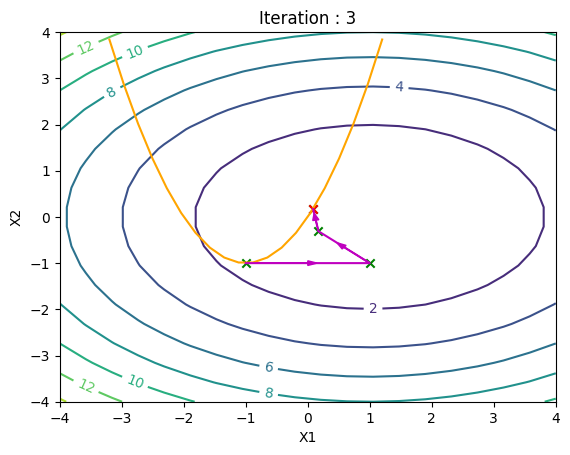

In [69]:
xnew, lambdanew = newton_step(xguess[:,-1].reshape(2,1),lambdaguess[-1])
xguess = torch.hstack([xguess, xnew])
lambdaguess.append(lambdanew)
i+=1
plot_steps(xguess.detach().numpy(),i)

รูปที่ 2.13 การลู่เข้าสู่คำตอบสำหรับค่าเริ่มต้น $x_0 = [-1.0, -1.0]$

สังเกตจากรูปที่ 2.13 ว่าในขั้นระหว่างการลู่เข้าสู่คำตอบ ค่าของ $x$ ไม่จำเป็นต้องอยู่บนเงื่อนไขบังคับ $c(x)=0$ ตลอดเวลา
จนกว่าจะถึงคำตอบสุดท้าย ตัวอย่างเช่นในขั้นแรกจะเห็นได้ชัดเจนว่าการปรับค่า $x$ สอดคล้องกับการประมาณค่าเชิงเส้น $c(x)$ คือเส้นตรงที่สัมผัสกับกราฟของ $c(x)$ ณ จุดเริ่มต้น นอกจากนั้นเราไม่ได้ใช้การค้นหาตามเส้นที่จะช่วยลดขนาดของการปรับค่า $x$ ลงได้

ต่อมาเมื่อทดลองค่าเริ่มต้น $x_0 = [-3.0, 2.0]$ พบว่าในครั้งนี้วิธีนิวตันไม่สามารถลู่เข้าสู่คำตอบได้ ดังแสดงในรูปที่ 2.14 
เหตุผลคือ แม้ในตัวอย่างนี้ $\nabla^2 f(x) \succ 0$ แต่เราไม่สามารถแน่ใจได้ว่า $\nabla_x^2 L \succ 0$ 
ดังนั้นทางแก้ปัญหาคือต้องทำเรกูลาร์ไรเซชัน ซึ่งจะเพิ่มความซับซ้อนในการคำนวณมากขึ้น 

In [70]:
xguess = torch.tensor([[-3.0],[2.0]],requires_grad=True)
lambdaguess = [0.0]
i=0

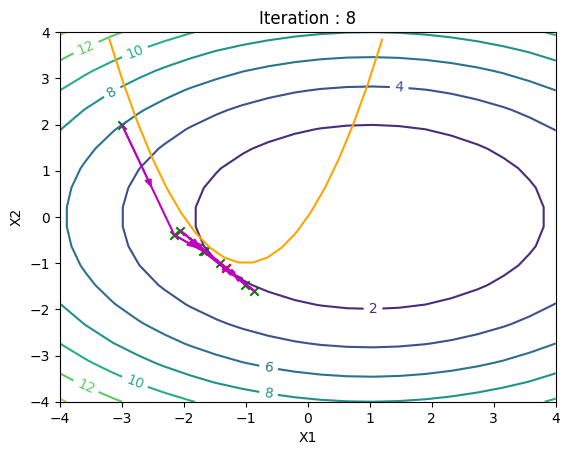

In [78]:
xnew, lambdanew = newton_step(xguess[:,-1].reshape(2,1),lambdaguess[-1])
xguess = torch.hstack([xguess, xnew])
lambdaguess.append(lambdanew)
i+=1
plot_steps(xguess.detach().numpy(),i)

รูปที่ 2.14 วิธีนิวตันไม่สามารถลู่เข้าสู่คำตอบได้เมื่อเลือก $x_0 = [-3.0, 2.0]$

เพื่อยืนยันเหตุผลนี้ ตรวจสอบค่าเฮสเชียน $\nabla^2 f(x)$ และ $\nabla_x^2 L$ ณ 
ตำแหน่ง $x$ ที่ได้จากขั้นสุดท้ายด้านบน จะเห็นได้ว่าเมทริกซ์เฮสเชียน $\nabla^2 f(x)$ เป็นแบบบวกแน่นอน

In [81]:
H_f = d2f(xnew)
H_f.numpy()

array([[0.5, 0. ],
       [0. , 1. ]], dtype=float32)

แต่เมทริกซ์ $\nabla_x^2 L$

In [82]:
H_L = d2f(xnew) + torch.squeeze(jacfwd(dc)(xnew)).T*lambdanew
H_L.detach().numpy()


array([[-1.7163854,  0.       ],
       [ 0.       ,  1.       ]], dtype=float32)

มีค่าลักษณะเฉพาะเป็นลบ ดังนั้นไม่เป็นแบบบวกแน่นอน ทำให้วิธีนิวตันไม่ลู่เข้าสู่ค่าต่ำสุด

หากเปลี่ยนเป็นใช้วิธีเกาส์-นิวตัน เฮสเชียนที่ใช้ในการคำนวณเหลือเพียงพจน์ $\nabla^2 f(x)$ เท่านั้น 
ซึ่งเป็นแบบบวกแน่นอนเพราะ $f(x)$ เป็นฟังก์ชันคอนเวกซ์ ดังนั้นจะไม่เกิดปัญหาการไม่ลู่เข้าสู่ค่าต่ำสุด 

เราจะทดลองใช้วิธีเกาส์-นิวตันเพื่อเปรียบเทียบ เขียนฟังก์ชัน gauss_newton_step() 
โดยเพียงตัดพจน์สุดท้ายของ (2.24) ออกไปเท่านั้น



In [83]:
def gauss_newton_step(x0,lambda0):
    H = d2f(x0) #+ torch.squeeze(jacfwd(dc)(x0)).T*lambda0
    C = dc(x0)
    A = torch.vstack([torch.hstack([H,C.T]),torch.hstack([C,torch.zeros(1,1)])])
    B = torch.vstack([-df(x0)-C.T*lambda0, -c(x0)])

    dz = solve(A,B)
    dx = dz[0:2]
    dlambda = dz[2]
    return x0+dx, lambda0+dlambda

ใช้ค่าเริ่มต้นเดิมคือ $x_0 = [-3.0,2.0]$ ได้ผลดังรูปที่ 2.14 ครั้งนี้พบว่าวิธีเกาส์-นิวตัน 
ใช้งานได้ดีกว่า โดยสามารถลู่เข้าสู่คำตอบได้หลังการวนซ้ำประมาณ 7 ครั้ง

In [84]:
xguess = torch.tensor([[-3.0],[2.0]],requires_grad=True)
lambdaguess = [0.0]
i=0

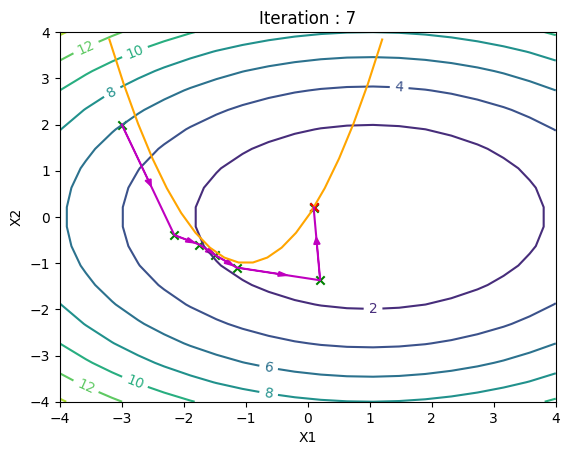

In [91]:
xnew, lambdanew = gauss_newton_step(xguess[:,-1].reshape(2,1),lambdaguess[-1])
xguess = torch.hstack([xguess, xnew])
lambdaguess.append(lambdanew)
i+=1
plot_steps(xguess.detach().numpy(),i)

รูปที่ 2.14 วิธีเกาส์-นิวตันสามารถลู่เข้าสู่คำตอบได้สำหรับค่าเริ่มต้น $x_0 = [-3.0, 2.0]$

สรุปประเด็นสำคัญสำหรับปัญหาการหาค่าต่ำสุดบนเงื่อนไขบังคับแบบสมการคือ ในปัญหาทั่วไป ฟังก์ชันมูลค่า $f(x)$ เป็นสิ่งที่เรากำหนดขึ้นเองตามความต้องการ ซึ่งสามารถเลือกให้มีคุณสมบัติที่เอื้ออำนวยต่อการหาคำตอบ เช่นเป็นฟังก์ชันรูปแบบกำลังสองหรือคอนเวกซ์ แตกต่างจากเงื่อนไขบังคับ $c(x)$ ที่เป็นสมการจากภายนอก เช่นพลวัตของพลานต์ในระบบควบคุม อาจมีความซับซ้อนกว่าและไม่สามารถกำหนดได้เอง ดังนั้นเงื่อนไขบังคับมักเป็นส่วนที่สร้างปัญหาทำให้ $\nabla_x^2 L$ ไม่เป็นแบบบวกแน่นอน ดังเช่นในตัวอย่าง 2.6 เป็นอีกเหตุผลหนึ่งที่ทำให้วิธีเกาส์-นิวตัน เป็นที่นิยมในทางปฎิบัติ

ในส่วนท้ายของบทนี้จะใช้วิธีการเรกูลาร์ไรเซชันเพื่อช่วยให้วิธีนิวตันสามารถลู่เข้าสู่คำตอบได้ 

***

<a id="ex2_8"></a>

### ตัวอย่าง 2.8 

ในตัวอย่างนี้จะใช้โจทย์เดิมจากตัวอย่าง 2.7 แต่เปลี่ยนวิธีหาคำตอบจาก AL เป็น IP 
นำเข้าแพ็กเกจที่ใช้งาน โดยจะใช้ torch ช่วยในการหาอนุพันธ์อัตโนมัติ 

In [92]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
from torch.linalg import norm, solve 
from torch.func import jacfwd

จาก (2.31) ใช้ข้อมูลเดิมเพื่อสร้างฟังก์ชันมูลค่า เงื่อนไขบังคับ และใช้ฟังก์ชัน landscape() เดิมจากตัวอย่าง 2.7 
พล็อตเส้นโค้งระดับของฟังก์ชันมูลค่าและเงื่อนไขบังคับเส้นตรง ดังแสดงในรูปที่ 2.21

In [93]:
Q = torch.diag(torch.tensor([0.5,1]))

# objective function
def f(x):
    x1 = x - torch.tensor([[1],[0]])

    return 0.5*(x1.T@Q@x1)[0,0]

# gradient 
def df(x):
    x1 = x - torch.tensor([[1],[0]])
    return Q@x1

# hessian 
def d2f(x):
    return Q

In [125]:
# constraint and gradient
A = torch.tensor([-1.0, 1.0]).reshape(2,1)
b = torch.tensor(1.0)
             
def c(x):
    # return (torch.dot(A.T,x) - b)
    return(A.T@x - b)


def dc(x):
    return A  


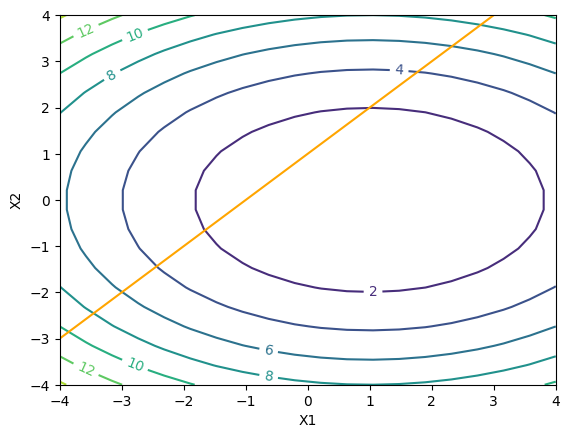

In [95]:
def plot_landscape():
    # plot level curve of f(x)
    Nsamp = 20
    x = np.linspace(-4,4,Nsamp)
    y = np.linspace(-4,4,Nsamp)
    X, Y = np.meshgrid(x,y)
    X = X.astype(np.float32)
    Y = Y.astype(np.float32)
    Z = np.zeros((Nsamp,Nsamp))
    for j in range(Nsamp):
        for k in range(Nsamp):
            Z[j,k] = f(torch.tensor([[X[j,k]], [Y[j,k]]]))
    fig, ax = plt.subplots()
    CS = ax.contour(X,Y,Z)
    ax.clabel(CS, fontsize = 10)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')

    # plot constraint c(x)
    xc = np.linspace(-4.0,3.0, Nsamp)
    yc = xc+1
    ax.plot(xc,yc,'orange')

    return ax

ax = plot_landscape()   

รูปที่ 2.21 เส้นโค้งระดับของ $f(x)$ ซ้อนทับบนเงื่อนไขแบบอสมการ $c(x)$

เขียนฟังก์ชัน ip_residual() เพื่อตรวจสอบ (2.46), (2.47) ว่ามีค่าแตกต่างจากศูนย์เท่าใด 

In [127]:
def ip_residual(z, rho):
    x = z[0:2]
    sigma = z[2]
    ru = df(x) - dc(x).T.reshape(2,1)*torch.sqrt(rho)*torch.exp(-sigma)
    rl = c(x) - torch.sqrt(rho)*torch.exp(sigma)
    r = torch.vstack([ru,rl])
    return r

สร้างฟังก์ชันเสริม kkt_residual() สำหรับตรวจสอบเงื่อนไข KKT 

In [132]:
def kkt_residual(z):
    x = z[0:2]
    sigma = z[2]
    Lambda = torch.sqrt(rho)*torch.exp(-sigma)

    ru = df(x) - dc(x).T.reshape(2,1)*Lambda
    t_zero = torch.zeros(1)
    r = torch.vstack([ru,torch.minimum(Lambda,t_zero),torch.minimum(c(x),t_zero),Lambda*c(x)])
    return r

เริ่มต้นทดสอบโดยเลือกค่าเริ่มต้น $x_0 = [-2.0, 2.0]$ ดังในรูปที่ 2.22

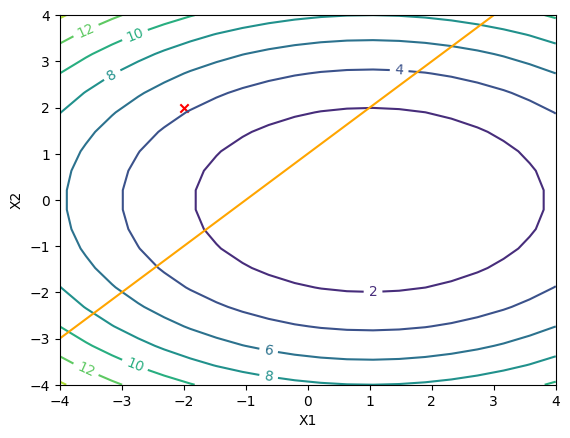

In [168]:
i=0
xguess = torch.tensor([[-2.0],[2.0]],requires_grad=True)
sigmaguess = torch.tensor([0.0], requires_grad=True)
z = torch.vstack([xguess, sigmaguess])
ax = plot_landscape()
xguess_np = xguess.detach().numpy()
ax.scatter(xguess_np[0], xguess_np[1],marker='x',color='r')
z_iter = z
plt.show()

รูปที่ 2.22 เลือกค่าเริ่มต้น $x_0 = [-2.0, 2.0]$ 

ในตัวอย่างนี้เราจะเริ่มต้นที่ $\rho=1.0$  และลดค่าลงในแต่ละขั้นเพื่อลู่เข้าสู่คำตอบ 
เพื่อแสดงเส้นทางของ $x$ เรียกว่าเส้นทางศูนย์กลาง (central path) 
แม้ว่าสำหรับปัญหาการหาค่าต่ำสุดแบบคอนเวกซ์ดังเช่นในตัวอย่างนี้ สามารถเริ่มจากค่า $\rho$ น้อยๆ ได้เลย 
ซึ่งจะทำให้ลู่เข้าสู่คำตอบได้ทันที 

เมื่อกำหนด $\rho = 1.0$ ตรวจสอบเอาต์พุตของ ip_residual() ณ จุดเริ่มต้น

In [136]:
rho = torch.tensor(1.0)
print(ip_residual(z,rho).detach().numpy())

[[-0.5]
 [ 1. ]
 [ 2. ]]


จะเห็นความแตกต่างจากศูนย์ โดย 2 สมาชิกแรกคือ (2.46) และสมาชิกสุดท้ายคือ (2.47) 
ต่อมาตรวจสอบเอาต์พุตจากเงื่อนไข KKT

In [137]:
print(kkt_residual(z).detach().numpy())

[[-0.5]
 [ 1. ]
 [ 0. ]
 [ 0. ]
 [ 3. ]]


2 สมาชิกแรกเป็นค่าเดียวกับที่ได้จาก ip_residual() สมาชิกที่ 3 และ 4 คือ $\lambda$ และ 
$c(x)$ ตามลำดับ ซึ่งจำกัดขอบเขตด้านบนด้วยค่าศูนย์ ดังนั้นหากเป็นศูนย์หมายความว่าเงื่อนไข KKT ไม่ถูกละเมิด 
ส่วนสมาชิกสูดท้ายคือ $\lambda c(x)$ ซึ่งเมื่อลู่เข้าสู่คำตอบ ค่านี้จะต้องลู่เข้าสู่ศูนย์

เขียนฟังก์ชัน ip_newton_solve() เพื่อหาคำตอบโดยวิธี IP ได้ดังนี้

In [160]:
def ip_newton_solve(z0,rho,tol):
    global M,r,dz

    # rho_global = rho
    # initial guess
    z = z0

    # KKT residual
    r = ip_residual(z,rho)

    while norm(r) > tol:
        # Newton step
        M = torch.squeeze(jacfwd(ip_residual,argnums=0)(z,rho))
        # M = jnp.asarray(jax.jacfwd(ip_residual_wrapper)(z)).reshape(3,3)
        dz = solve(-M,r)
        znew = z + dz
        rnew = ip_residual(znew,rho)
        # inexpensive line search
        b = 0.1
        d = 0.5
        alpha = 1.0
        norm_r = norm(r)
        while norm(rnew) > (norm_r + b*alpha*r.T@M@dz/norm_r):
            alpha = d*alpha
            znew = z + alpha*dz
            rnew = ip_residual(znew,rho)

        z = znew
        r = rnew

    return z

ใช้ฟังก์ชัน plot_steps() จากตัวอย่างก่อนหน้า

In [139]:
def plot_steps(xguess,i):
    ax = plot_landscape()
    ax.scatter(xguess[0,:], xguess[1,:],marker='x',color='g') 
    ax.scatter(xguess[0,-1], xguess[1,-1],marker='x',color='r')
    for ix in range(xguess.shape[1]-1):
        x1_old = xguess[0,ix]
        x1_new = xguess[0,ix+1]
        x2_old = xguess[1,ix]
        x2_new = xguess[1,ix+1]
        if np.linalg.norm(xguess[:,ix] - xguess[:,ix+1]).item() > 0.1: # plot arrow if distance large enough
            ax.arrow(x1_old,x2_old,(x1_new-x1_old)/2,(x2_new-x2_old)/2,head_width=0.1,color='m')
    ax.plot(xguess[0,:], xguess[1,:],'m') 
    ax.set_title('Iteration : '+str(i))

เพื่อความสะดวก คัดลอกเซลล์ตั้งค่าเริ่มต้นจากด้านบนมาอีกครั้งหนึ่ง

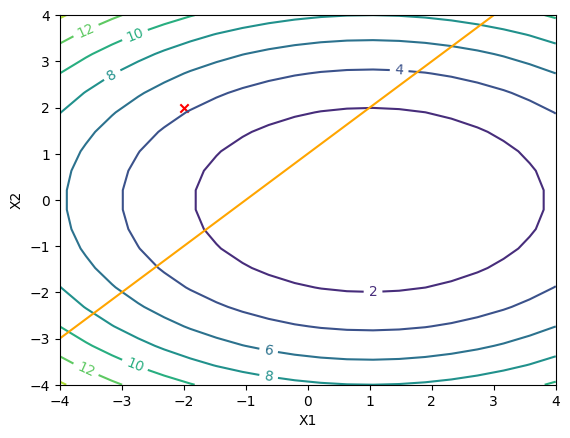

In [177]:
i=0
rho_hist=[]
xguess = torch.tensor([[-2.0],[2.0]],requires_grad=True)
sigmaguess = torch.tensor([0.0], requires_grad=True)
z = torch.vstack([xguess, sigmaguess])
ax = plot_landscape()
xguess_np = xguess.detach().numpy()
ax.scatter(xguess_np[0], xguess_np[1],marker='x',color='r')
z_iter = z
plt.show()

รันเซลล์ด้านล่างนี้ซ้ำ โดยลดค่าตัวแปร rho จากค่าเริ่มต้น 1.0 น้อยลงจนถึงค่าที่ต้องการ เช่น 1e-8 
ใช้ฟังก์ชัน plot_steps() ที่นิยามในตัวอย่าง 2.7 เพื่อดูการลู่เข้าสู่คำตอบของค่า $x$ ดังแสดงในรูปที่ 2.23

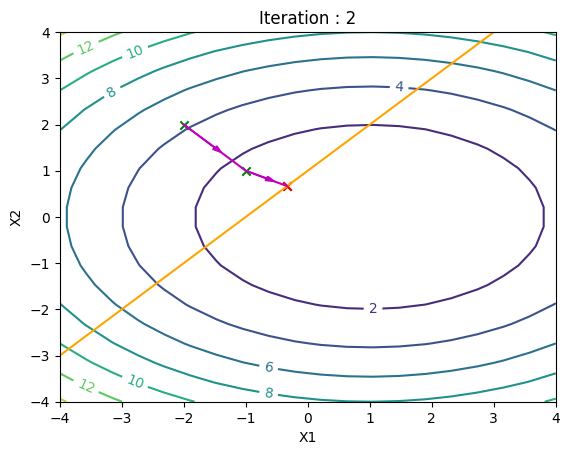

In [179]:
rho = torch.tensor(1e-8) # reduce from 1.0 down to very small, say, 1e-8
z = ip_newton_solve(z_iter[:,-1].reshape(3,1), rho, 1e-6)
z_iter = torch.hstack([z_iter,z])
rho_hist.append(rho.detach().numpy())
i+=1 
plot_steps(z_iter.detach().numpy(),i)

รูปที่ 2.23 การลู่เข้าสู่คำตอบของวิธี IP 

ค่าของ rho ที่ใช้จะถูกเก็บในลิสต์ rho_hist

In [188]:
for i in range(len(rho_hist)):
    print("iteration {} : rho = {}".format(i,rho_hist[i]))

iteration 0 : rho = 1.0
iteration 1 : rho = 9.99999993922529e-09


เปรียบเทียบค่าคำตอบที่ได้จากวิธี IP กับวิธี AL ในตัวอย่าง 2.7

In [190]:
z[0:2].detach().numpy()

array([[-0.33333337],
       [ 0.6666667 ]], dtype=float32)

เอาต์พุตจากฟังก์ชัน ip_residual() และ kkt_residual() จะต้องใกล้เคียงศูนย์ที่จุดคำตอบ

In [192]:
ip_residual(z,rho).detach().numpy()

array([[ 6.5565109e-07],
       [-6.5565109e-07],
       [-1.4999983e-08]], dtype=float32)

In [194]:
kkt_residual(z).detach().numpy()

array([[ 6.556511e-07],
       [-6.556511e-07],
       [ 0.000000e+00],
       [ 0.000000e+00],
       [ 0.000000e+00]], dtype=float32)

*** 

<a id="ex2_9"></a>

### ตัวอย่าง 2.9

จากตัวอย่าง 2.6 เราได้เห็นปัญหาการไม่ลู่เข้าสู่คำตอบเม่ือเลือกค่าเริ่มต้น $x_0 = [-3.0,2.0]$ 
โดยในตัวอย่างนั้นเราแก้ไขโดยใช้วิธีเกาส์-นิวตัน ซึ่งตัดพจน์ที่ทำให้เฮสเชียนไม่เป็นแบบบวกแน่นอนออกไป 
อีกทางเลือกหนึ่งในการแก้ปัญหาในกรณีต้องการใช้วิธีนิวตันคือการทำเรกูลาร์ไรเซชัน (2.57) 

เพื่อความสะดวกในการอธิบายจะแสดงผลจากค่าเริ่มต้น $x_0 = [-3.0,2.0]$ จากตัวอย่าง 2.6 อีกครั้งหนึ่งในรูปที่ 
2.24 คือกรณีที่วิธีนิวตันไม่ลู่เข้าสู่คำตอบ โดยใช้ข้อมูลเดิมจากตัวอย่าง 2.6 ทั้งหมด



In [195]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
from torch.linalg import norm, solve, eig
from torch.func import jacfwd

In [196]:
Q = torch.diag(torch.tensor([0.5,1]))

# objective function
def f(x):
    x1 = x - torch.tensor([[1],[0]])

    return 0.5*(x1.T@Q@x1)[0,0]

# gradient 
def df(x):
    x1 = x - torch.tensor([[1],[0]])
    return Q@x1

# hessian 
def d2f(x):
    return Q

# constraint and gradient
def c(x):
    return (x[0]**2 + 2*x[0] - x[1]) 

def dc(x):
    gradC = torch.zeros(1,2)
    gradC[0,0] = 2*x[0]+2
    gradC[0,1] = -1
    return gradC 

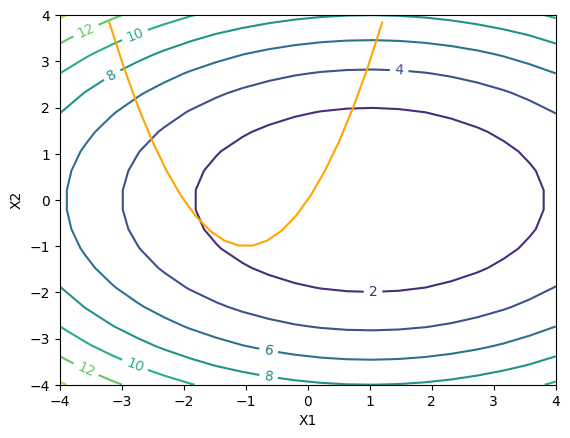

In [197]:
def plot_landscape():
    # plot level curve of f(x)
    Nsamp = 20
    x = np.linspace(-4,4,Nsamp)
    y = np.linspace(-4,4,Nsamp)
    X, Y = np.meshgrid(x,y)
    X = X.astype(np.float32)
    Y = Y.astype(np.float32)
    Z = np.zeros((Nsamp,Nsamp))
    for j in range(Nsamp):
        for k in range(Nsamp):
            Z[j,k] = f(torch.tensor([[X[j,k]], [Y[j,k]]]))
    fig, ax = plt.subplots()
    CS = ax.contour(X,Y,Z)
    ax.clabel(CS, fontsize = 10)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')

    # plot constraint c(x)
    xc = np.linspace(-3.2,1.2, Nsamp)
    yc = xc**2+2.0*xc
    ax.plot(xc,yc,'orange')

    return ax

ax = plot_landscape()   

In [198]:
def newton_step(x0,lambda0):
    H = d2f(x0) + torch.squeeze(jacfwd(dc)(x0)).T*lambda0
    C = dc(x0)
    A = torch.vstack([torch.hstack([H,C.T]),torch.hstack([C,torch.zeros(1,1)])])
    B = torch.vstack([-df(x0)-C.T*lambda0, -c(x0)])

    dz = solve(A,B)
    dx = dz[0:2]
    dlambda = dz[2]
    return x0+dx, lambda0+dlambda

In [199]:
def plot_steps(xguess,i):
    ax = plot_landscape()
    ax.scatter(xguess[0,:], xguess[1,:],marker='x',color='g') 
    ax.scatter(xguess[0,-1], xguess[1,-1],marker='x',color='r')
    for ix in range(xguess.shape[1]-1):
        x1_old = xguess[0,ix]
        x1_new = xguess[0,ix+1]
        x2_old = xguess[1,ix]
        x2_new = xguess[1,ix+1]
        if np.linalg.norm(xguess[:,ix] - xguess[:,ix+1]).item() > 0.1: # plot arrow if distance large enough
            ax.arrow(x1_old,x2_old,(x1_new-x1_old)/2,(x2_new-x2_old)/2,head_width=0.1,color='m')
    ax.plot(xguess[0,:], xguess[1,:],'m') 
    ax.set_title('Iteration : '+str(i))

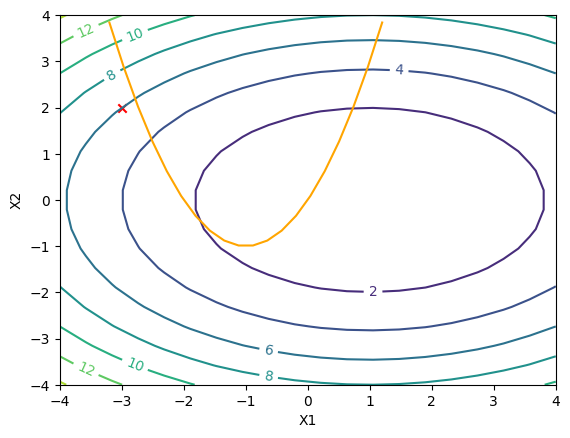

In [216]:
i=0
xguess = torch.tensor([[-3.0],[2.0]],requires_grad=True)
lambdaguess = [0.0]
ax = plot_landscape()
xguess_np = xguess.detach().numpy()
ax.scatter(xguess_np[0], xguess_np[1],marker='x',color='r')
plt.show()

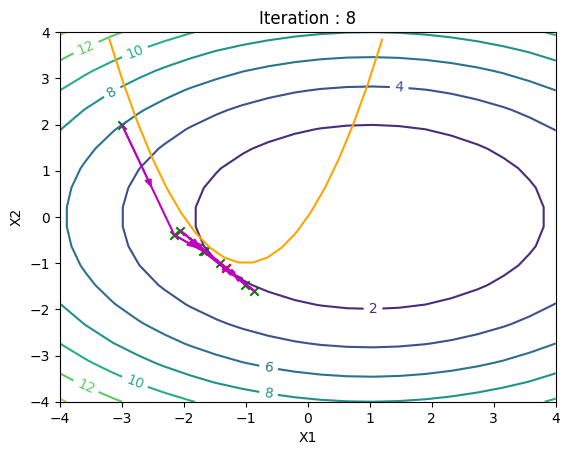

In [224]:
xnew, lambdanew = newton_step(xguess[:,-1].reshape(2,1),lambdaguess[-1])
xguess = torch.hstack([xguess, xnew])
lambdaguess.append(lambdanew)
i+=1
plot_steps(xguess.detach().numpy(),i)

รูปที่ 2.24 ปัญหาการไม่ลู่เข้าสู่คำตอบเมื่อเลือกค่าเริ่มต้น $x_0 = [-3.0, 2.0]$

ตรวจสอบค่าลักษณะเฉพาะของเมทริกซ์ทางด้านซ้ายของ (2.23)

In [226]:
xr = xguess[:,-1].reshape(2,1)
H = d2f(xr) + torch.squeeze(jacfwd(dc)(xr)).T*lambdaguess[-1]
C = dc(xr)
A = torch.vstack([torch.hstack([H,C.T]),torch.hstack([C,torch.zeros(1,1)])])
evalA, evecA = eig(A)
print(evalA.detach().numpy())

[-1.9624485 +0.j -0.40606707+0.j  1.6521305 +0.j]


พบว่ามีค่าลบ 2 ตัวและค่าบวก 1 ตัว ซึ่งผิดไปจากจุดอานม้าที่นิยามโดยเงื่อนไข KKT 
ต้องการค่าลักษณะเฉพาะเป็นบวกจำนวน $dim(x) = 2$ และค่าลบจำนวน $dim(\lambda) = 1$ 
ดังนั้นจึงต้องทำเรกูลาร์ไรเซชันตาม (2.57) เขียนเป็นฟังก์ชันได้ดังนี้

In [255]:
def regularized_newton_step(x0,lambda0):
    global A, xlen, lambdalen
    lambdalen = 1 # len(lambda0)
    xlen = len(x0)
    beta = 1.0
    H = d2f(x0) + + torch.squeeze(jacfwd(dc)(x0)).T*lambda0
    C = dc(x0)
    A = torch.vstack([torch.hstack([H,C.T]),torch.hstack([C,torch.zeros(1,1)])])
    evalA, evecA = eig(A)
    Rx = beta*torch.ones(xlen)
    Rl = -beta*torch.ones(1)
    R = torch.diag(torch.hstack([Rx,Rl]))    
    while not (sum(evalA.real>0)==xlen and sum(evalA.real<0)==lambdalen):
        A += R
        evalA, evecA = eig(A)
    B = torch.vstack([-df(x0)-C.T*lambda0, -c(x0)])
    dz = solve(A,B)
    dx = dz[0:2]
    dlambda = dz[2]
    return x0+dx, lambda0+dlambda

ทดลองใช้ regularized_newton_step() กับค่าเริ่มต้นเดิม ได้ผลดังในรูปที่ 2.25 
จะเห็นได้ว่าการทำเรกูลาร์ไรเซชันช่วยให้วิธีนิวตันลู่เข้าสู่คำตอบได้

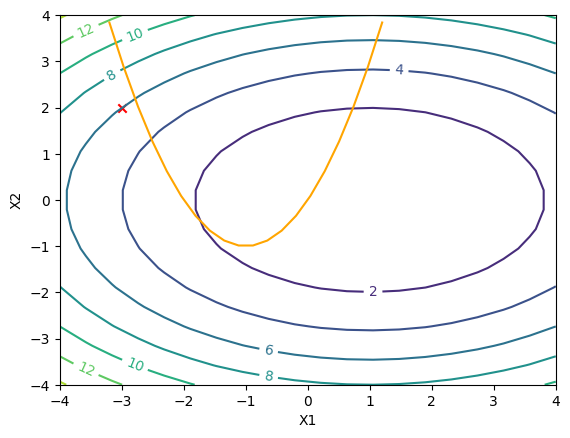

In [247]:
i=0
xguess = torch.tensor([[-3.0],[2.0]],requires_grad=True)
lambdaguess = [0.0]
ax = plot_landscape()
xguess_np = xguess.detach().numpy()
ax.scatter(xguess_np[0], xguess_np[1],marker='x',color='r')
plt.show()

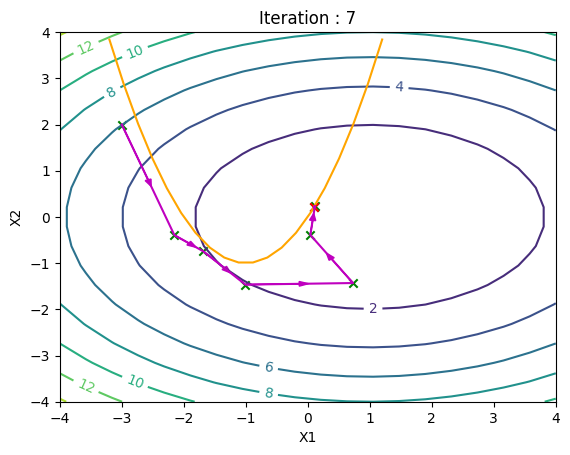

In [262]:
xnew, lambdanew = regularized_newton_step(xguess[:,-1].reshape(2,1),lambdaguess[-1])
xguess = torch.hstack([xguess, xnew])
lambdaguess.append(lambdanew)
i+=1
plot_steps(xguess.detach().numpy(),i)

รูปที่ 2.25 การทำเรกูลาร์ไรเซชันช่วยให้วิธีนิวตันลู่เข้าสู่คำตอบ


***

<a id="ex2_10"></a>

### ตัวอย่าง 2.10

ตัวอย่างนี้ยังคงใช้ข้อมูลเดิมจากตัวอย่าง 2.9 รวมถึงฟังก์ชัน 
plot_landscape() และ plot_steps() เหมือนเดิมทุกประการ
ในการหาคำตอบจะใช้วิธีเกาส์-นิวตัน 
ซึ่งฟังก์ชันนี้มีการแก้ไขเล็กน้อยให้คืนค่าเฉพาะค่าเปลี่ยนแปลงในแต่ละขั้นสำหรับ $x$ และ $\lambda$ 
เพื่อเอื้ออำนวยกับวิธีการค้นหาตามเส้น


In [263]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
from torch.linalg import norm, solve, eig
from torch.func import jacfwd

In [264]:
Q = torch.diag(torch.tensor([0.5,1]))

# objective function
def f(x):
    x1 = x - torch.tensor([[1],[0]])

    return 0.5*(x1.T@Q@x1)[0,0]

# gradient 
def df(x):
    x1 = x - torch.tensor([[1],[0]])
    return Q@x1

# hessian 
def d2f(x):
    return Q

# constraint and gradient
def c(x):
    return (x[0]**2 + 2*x[0] - x[1]) 

def dc(x):
    gradC = torch.zeros(1,2)
    gradC[0,0] = 2*x[0]+2
    gradC[0,1] = -1
    return gradC 

In [266]:
def plot_landscape():
    # plot level curve of f(x)
    Nsamp = 20
    x = np.linspace(-4,4,Nsamp)
    y = np.linspace(-4,4,Nsamp)
    X, Y = np.meshgrid(x,y)
    X = X.astype(np.float32)
    Y = Y.astype(np.float32)
    Z = np.zeros((Nsamp,Nsamp))
    for j in range(Nsamp):
        for k in range(Nsamp):
            Z[j,k] = f(torch.tensor([[X[j,k]], [Y[j,k]]]))
    fig, ax = plt.subplots()
    CS = ax.contour(X,Y,Z)
    ax.clabel(CS, fontsize = 10)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')

    # plot constraint c(x)
    xc = np.linspace(-3.2,1.2, Nsamp)
    yc = xc**2+2.0*xc
    ax.plot(xc,yc,'orange')

    return ax

def plot_steps(xguess,i):
    ax = plot_landscape()
    ax.scatter(xguess[0,:], xguess[1,:],marker='x',color='g') 
    ax.scatter(xguess[0,-1], xguess[1,-1],marker='x',color='r')
    for ix in range(xguess.shape[1]-1):
        x1_old = xguess[0,ix]
        x1_new = xguess[0,ix+1]
        x2_old = xguess[1,ix]
        x2_new = xguess[1,ix+1]
        if np.linalg.norm(xguess[:,ix] - xguess[:,ix+1]).item() > 0.1: # plot arrow if distance large enough
            ax.arrow(x1_old,x2_old,(x1_new-x1_old)/2,(x2_new-x2_old)/2,head_width=0.1,color='m')
    ax.plot(xguess[0,:], xguess[1,:],'m') 
    ax.set_title('Iteration : '+str(i))  

In [267]:
# modified slightly
def gauss_newton_stepd(x0,lambda0):
    H = d2f(x0) # + torch.squeeze(jacfwd(dc)(x0)).T*lambda0
    C = dc(x0)
    A = torch.vstack([torch.hstack([H,C.T]),torch.hstack([C,torch.zeros(1,1)])])
    B = torch.vstack([-df(x0)-C.T*lambda0, -c(x0)])

    dz = solve(A,B)
    dx = dz[0:2]
    dlambda = dz[2]
    return dx, dlambda # return only the steps
#    return x0+dx, lambda0+dlambda


กำหนดค่าเริ่มต้น $x_0 = [-1.0, -1.0]$ ผลจากวิธีนิวตันในตัวอย่าง 2.6 แสดงให้เห็นถึงการก้าวกระโดดที่มีขนาดใหญ่
โดยเฉพาะในขั้นแรก ดังนั้นจะใช้วิธีการค้นหาตามเส้นเพื่อลดขนาดการเปลี่ยนแปลงของตัวแปร 

เริ่มการทดสอบจากฟังก์ชันเมอริต P() ตาม (2.62) และเกรเดียนต์ dP() 

In [268]:
def P(x, _lambda):
    dL_u = -df(x) - dc(x).T*_lambda
    dL = torch.vstack([dL_u, -c(x)])
    return 0.5*dL.T@dL

def dP(x, _lambda):
    H = d2f(x)  + torch.squeeze(jacfwd(dc)(x)).T*_lambda  
    C = dc(x)
    A = torch.vstack([torch.hstack([H,C.T]),torch.hstack([C,torch.zeros(1,1)])]) 
    B = torch.vstack([-df(x)-C.T*_lambda, -c(x)])    
    return A@B

กำหนดค่าเริ่มต้น

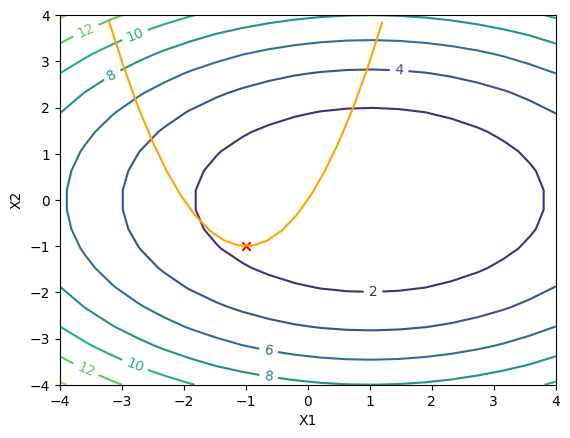

In [269]:
i=0
xguess = torch.tensor([[-1.0],[-1.0]],requires_grad=True)
lambdaguess = [0.0]
ax = plot_landscape()
xguess_np = xguess.detach().numpy()
ax.scatter(xguess_np[0], xguess_np[1],marker='x',color='r')
plt.show()

รันเซลล์ด้านล่างนี้ซ้ำจำนวนตามต้องการ เพื่อดูผลการลู่เข้าสู่คำตอบของวิธีเกาส์-นิวตันที่มีการค้นหาตามเส้น 
ผลที่ได้แสดงดังในรูปที่ 2.26 เมื่อเปรียบเทียบกับผลในรูปที่ 2.13 จะเห็นว่าการก้าวกระโดดในขั้นแรกๆ จะลดลง 
ทำให้ค่าของ $x$ อยู่ใกล้กับเงื่อนไขบังคับมากขึ้น

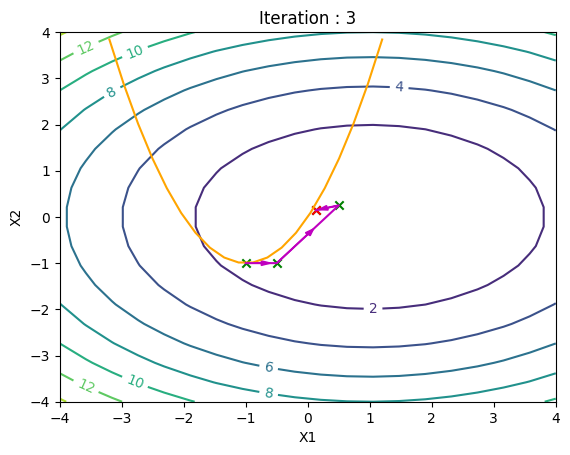

In [272]:
xr = xguess[:,-1].reshape(2,1)
dX, dLambda = gauss_newton_stepd(xr,lambdaguess[-1])
alpha = 1.0
xlast = xguess[:,-1].reshape(2,1)
while (P(xlast+alpha*dX, lambdaguess[-1]+alpha*dLambda) > P(xlast,lambdaguess[-1])
        + 0.01*alpha*dP(xlast, lambdaguess[-1]).T@torch.vstack([dX,dLambda])):
    alpha = 0.5*alpha
xguess = torch.hstack([xguess, xguess[:,-1].reshape(2,1)+alpha*dX])
lambdaguess.append(lambdaguess[-1]+alpha*dLambda)
i+=1
plot_steps(xguess.detach().numpy(),i)

รูปที่ 2.26 การลู่เข้าสู่คำตอบของวิธีเกาส์-นิวตันที่มีการค้นหาตามเส้น (2.62) 

ต่อมาทดสอบฟังก์ชันเมอริต (2.64) และเกรเดียนต์ พบว่าผลที่ได้เมื่อตั้งค่า $\rho = 1.0$ ใกล้เคียงกัน 
ดังแสดงในรูปที่ 2.27

In [274]:
rho = 1.0
def P(x, _lambda):
    return f(x) + rho*norm(torch.tensor([c(x)]))

def dP(x, _lambda):
    C = dc(x)
    dp_u = df(x) + rho*C.T*torch.sign(c(x))
    dp_l = torch.zeros(1,1)
    return torch.vstack([dp_u,dp_l])

In [279]:
i=0
xguess = torch.tensor([[-1.0],[-1.0]],requires_grad=True)
lambdaguess = [0.0]

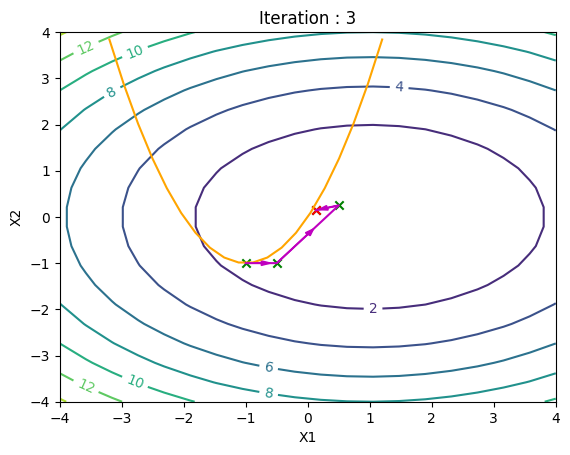

In [282]:
xr = xguess[:,-1].reshape(2,1)
dX, dLambda = gauss_newton_stepd(xr,lambdaguess[-1])
alpha = 1.0
xlast = xguess[:,-1].reshape(2,1)
while (P(xlast+alpha*dX, lambdaguess[-1]+alpha*dLambda) > P(xlast,lambdaguess[-1])
        + 0.01*alpha*dP(xlast, lambdaguess[-1]).T@torch.vstack([dX,dLambda])):
    alpha = 0.5*alpha
xguess = torch.hstack([xguess, xguess[:,-1].reshape(2,1)+alpha*dX])
lambdaguess.append(lambdaguess[-1]+alpha*dLambda)
i+=1
plot_steps(xguess.detach().numpy(),i)

รูปที่ 2.27 การลู่เข้าสู่คำตอบของวิธีเกาส์-นิวตันที่มีการค้นหาตามเส้น (2.64) 

สังเกตจาก (2.64) ว่าตัวแปร $\rho$ เป็นไฮเปอร์พารามิเตอร์ที่สามารถปรับได้ 
ซึ่งเมื่อเพิ่มค่าจะทำให้ขนาดการเปลี่ยนแปลงเล็กลง ดังนั้นการลู่เข้าสู่คำตอบใกล้กับเงื่อนไขบังคับมากขึ้น 
แต่ก็จะใช้จำนวนขั้นและเวลามากขึ้นด้วย รูปที่ 2.28 แสดงผลการลู่เข้าสู่คำตอบเมื่อกำหนด $\rho = 10$ 
ซึ่งแม้ว่าการเคลื่อนที่ของ $x$ ใกล้กับเงื่อนไขบังคับตลอดเวลา 
แต่อาจไม่ใช่สิ่งที่พึงประสงค์เนื่องจากใช้เวลานานกว่าจะเข้าสู่คำตอบ

In [283]:
rho = 10.0
i=0
xguess = torch.tensor([[-1.0],[-1.0]],requires_grad=True)
lambdaguess = [0.0]

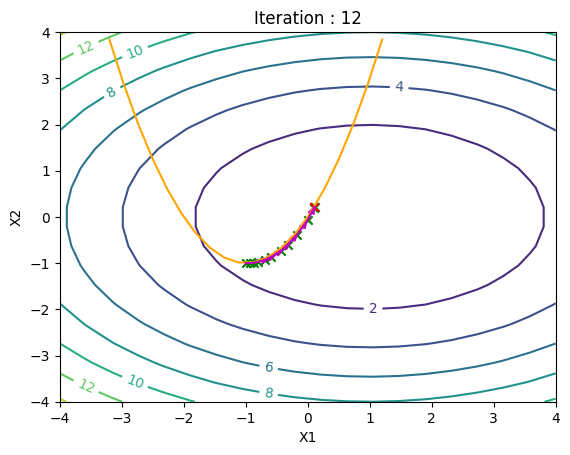

In [295]:
xr = xguess[:,-1].reshape(2,1)
dX, dLambda = gauss_newton_stepd(xr,lambdaguess[-1])
alpha = 1.0
xlast = xguess[:,-1].reshape(2,1)
while (P(xlast+alpha*dX, lambdaguess[-1]+alpha*dLambda) > P(xlast,lambdaguess[-1])
        + 0.01*alpha*dP(xlast, lambdaguess[-1]).T@torch.vstack([dX,dLambda])):
    alpha = 0.5*alpha
xguess = torch.hstack([xguess, xguess[:,-1].reshape(2,1)+alpha*dX])
lambdaguess.append(lambdaguess[-1]+alpha*dLambda)
i+=1
plot_steps(xguess.detach().numpy(),i)

รูปที่ 2.28 การเคลื่อนที่สู่คำตอบสำหรับการค้นหาตามเส้น (2.64) เมื่อกำหนด $\rho=10$

## บรรณานุกรม

1. Z. Manchester et.al. 16-745 Optimal Control & Reinforcement Learning, 
Course materials, Carnegie Mellon University. 2024,2025.

2. L. Armijo. Minimization of funcionts having Libschitz coninuous first partial 
derivative. Pacific J. Math. 16(1):1-3. 1966.

3. W. Karush. Minima of Functions of Several Variables with Inequalities as Side Constraints. (M.Sc. thesis). Dept. of Mathematics, Univ. of Chicago, Chicago, Illinois. 1939.

4. H.W. Kuhn and A.W. Tucker. Nonlinear Programming. Proceedings of 2nd Berkeley Symposium. Berkeley. Univ. of California Press. pp. 481-492. 1951.

5. A. Wächter and L. T. Biegler. On the Implementation of a Primal-Dual Interior Point Filter Line Search Algorithm for Large-Scale Nonlinear Programming, Mathematical Programming 106(1), pp. 25-57, 2006.

6. F. Permenter. Log-domain interior-point methods for convex quadratic progrmming. Optimization Letter 17 pp. 1613-1631. 2023.

<div align="center">
<img src="https://raw.githubusercontent.com/dewdotninja/sharing-github/refs/heads/master/dewninja_logo50.jpg" alt="dewninja"/>
</div>
<div align="center">dew.ninja 2025</div>